# Islanding detection based on CNN
In this notebook, convolutional neural networks are used in order to detect islanding events extracted from a Matlab/Simulink simulation. The dataset was gathered using a 100kW grid-connected photovoltaic system based on https://www.mathworks.com/help/physmod/sps/ug/detailed-model-of-a-100-kw-grid-connected-pv-array.html. The diagram of the model can be seen in the next image:

![Title](https://drive.google.com/uc?export=view&id=13GTwdyM12cX78Vo4cwxsjMt0zEuEh3V_)



The dataset was constructed by changing the active power of a Load connected at the point of common coupling through values between 90kW and 110kW. First, the voltage at each phase in the point of common coupling was measured and concatenated in a single array. Then, this time-series data was  converted into images using the wavelet tranform with a Morlet wavelet, generating the dataset used for this project. Each event in the dataset was generated at time 0.2s in the simulation. The voltage used was measured between seconds 0.2s and 0.35s. The sample rate for the data generated was 2e-05s. The scenarios included in the dataset can be seen in the following table:

| - |Grid-connected C_ON|Grid-connected C_OFF|Sudden swithcing OFF C|Sudden switching ON C| Islanding event C_ON  | Islanding event C_OFF | LL-fault | LN-fault | Total |
|---| --- | --- | --- | --- | --- |--- |--- | --- | --- |
| # Events | 100 | 100 | 100 | 100 | 100 |  100 | 100 | 100 | 800 |
| Label | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | --- |


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style()
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the next cell, several images from the different scenarios in the dataset collected are ploted. As it can be seen, many of the images seem to be the same when they are not.

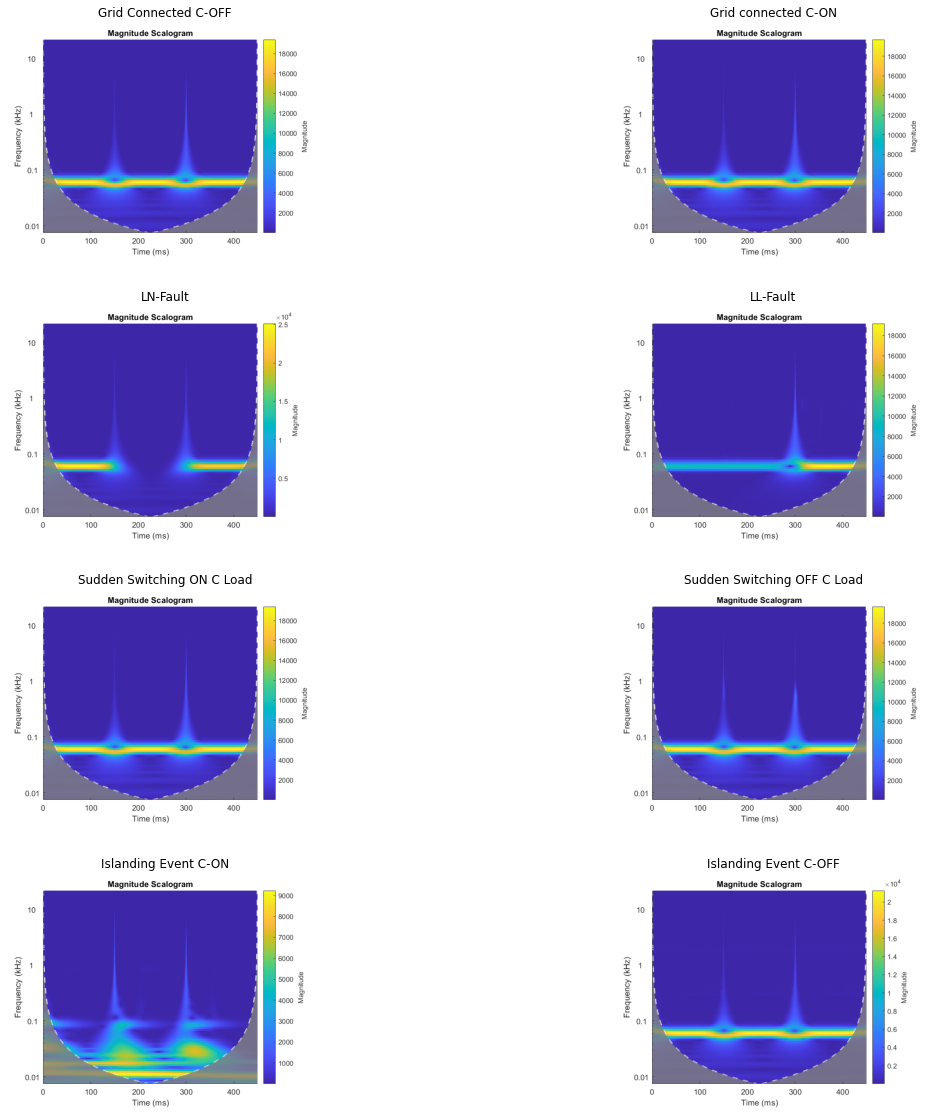

In [3]:
f, axarr = plt.subplots(4,2, figsize=(20,20))
images = os.listdir("/content/drive/MyDrive/ML in PV systems/Islanding/img/graphs")
counter = 0
for a in range(len(axarr)):
    for b in range(len(axarr[a])):
        img = image.load_img("/content/drive/MyDrive/ML in PV systems/Islanding/img/graphs/" + images[counter])
        axarr[a,b].axis('off')
        axarr[a,b].imshow(img)
        axarr[a,b].set_title(images[counter][:images[counter].find(".png")])
        counter += 1

In [4]:
def graficarMatrizConfusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  

    plt.figure(figsize=(8,8))

    ax = sns.heatmap(cm, annot = True, cbar = False);
      
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
      
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confussion Matrix")

    plt.show()

The next cell extracts the dataset from the .mat file generated. Each image had a size of (224, 224, 3). The dataset is composed of three columns, the first column corresponds to the value of the load at the moment of generating the the data, the second column corresponds to the image generated from the wavelet transform and the thrid column has the label of the data selected.

In [5]:
from scipy.io import loadmat
import numpy as np
import h5py
filename = "/content/drive/MyDrive/ML in PV systems/Islanding/dataset_IDM.mat"
with h5py.File(filename, 'r') as f:
    ref_label = np.array(f['dataset']['label'])
    labels = np.array([int(np.array(f[f['dataset']['label'][i][0]]).squeeze()) for i in range(0, len(ref_label))])
    images = np.array([np.array(f[f['dataset']['data'][i][0]]).squeeze() for i in range(0, len(ref_label))]).reshape(-1,224,224,3)

<function matplotlib.pyplot.show>

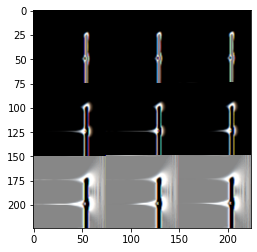

In [6]:
import matplotlib.image as mpimg
from PIL import Image
imgplot = plt.imshow(np.clip(images[701], 0, 1))
plt.show

We proceed to separate the dataset between training and testing values in the next cell.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.33, random_state = 42)

### Convolutional Neural Network Model

In [8]:
tf.random.set_seed(51)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape = (224, 224, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(8, activation='softmax')
    ])
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['sparse_categorical_accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(dataset[0][], , test_size=0.33, random_state=42)
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, verbose = 1)

Epoch 1/100
17/17 [==============================] - 13s 120ms/step - loss: 1.9566 - sparse_categorical_accuracy: 0.2108 - val_loss: 1.6108 - val_sparse_categorical_accuracy: 0.3902
Epoch 2/100
17/17 [==============================] - 1s 75ms/step - loss: 1.3987 - sparse_categorical_accuracy: 0.4869 - val_loss: 1.2196 - val_sparse_categorical_accuracy: 0.6288
Epoch 3/100
17/17 [==============================] - 1s 76ms/step - loss: 1.0473 - sparse_categorical_accuracy: 0.6642 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.6705
Epoch 4/100
17/17 [==============================] - 1s 76ms/step - loss: 0.8966 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.7344 - val_sparse_categorical_accuracy: 0.6288
Epoch 5/100
17/17 [==============================] - 1s 75ms/step - loss: 0.7927 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.5815 - val_sparse_categorical_accuracy: 0.7992
Epoch 6/100
17/17 [==============================] - 1s 76ms/step - loss: 0.7426 - sparse_categori

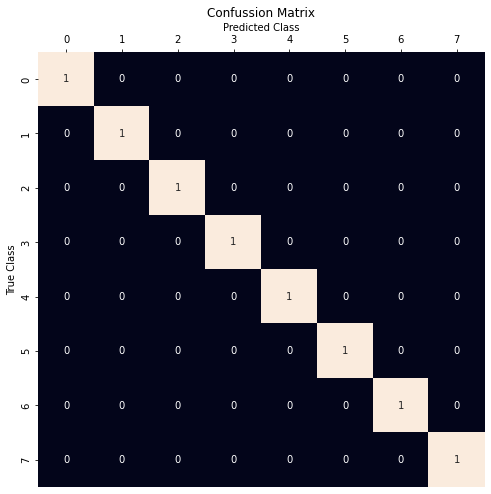

In [12]:
graficarMatrizConfusion(y_true = y_test, y_pred = np.argmax(model.predict(x_test),axis=1))

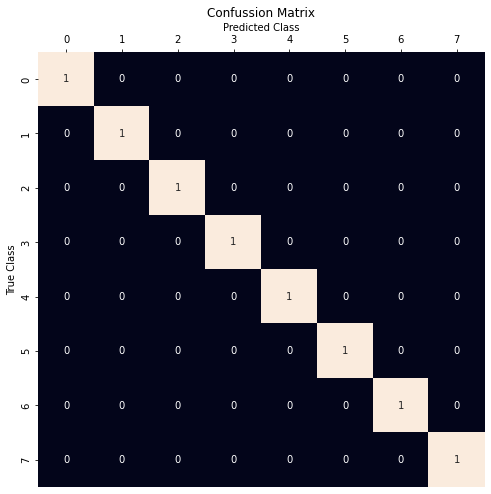

In [13]:
graficarMatrizConfusion(y_true = y_train, y_pred = np.argmax(model.predict(x_train),axis=1))